### Задание
1) Выбратьь по 6 предсказаний пользователей

2) Удаитьь фейковый эллемент 999999

3) Для каждого пользователя доллжно остаться по 5 отсортированных предсказаний

4) Посчиитать метрики map@5 и precision@5

_____

Загружаем файлы, импортируем библиотеки и самописные модули:

In [1]:
# !pip install pyspark pyarrow implicit==0.6.0 lightfm

In [2]:
!chmod +x metrics.py distributed_recommenders.py utils.py

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import legend

from pyspark.sql import SparkSession

from metrics import precision_at_k, recall_at_k, average_precision_at_k
from utils import prefilter_items, get_result_table
from recommenders import MainDistributedRecommender, MatrixTransformation

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_response_file_names = [f'retail_train_small_{i}.csv' for i in range(11)]
data = pd.concat([pd.read_csv(name) for name in data_response_file_names], ignore_index=True)
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

data_train = data[data['week_no'] < data['week_no'].max() - 3]
data_test = data[data['week_no'] >= data['week_no'].max() - 3]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


Сокращем раазмер:

In [5]:
n_items_beforre = data_train['item_id'].nunique()
data_train = prefilter_items(data_train, 5000, item_features)
n_items_after = data_train['item_id'].nunique()

print(f'было {n_items_beforre} стало {n_items_after}')

было 86865 стало 5001


Разреженная матрица:

In [6]:
main_data_train = MatrixTransformation(data_train)
user_item_matrix = main_data_train.user_item_matrix
user_item_matrix.head(3)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Истинные значения:

In [7]:
result = get_result_table(data_test)
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


Словари:

In [8]:
id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = (
    main_data_train.id_to_itemid,
    main_data_train.id_to_userid,
    main_data_train.itemid_to_id,
    main_data_train.userid_to_id
)

## SparkSession

In [9]:
session = (
    SparkSession.builder.config('spark.driver.memory', '2g')
    .config('spark.sql.shuffle.partitions', '100')
    .config('spark.driver.bindAddress', '127.0.0.1')
    .config('spark.driver.host', 'localhost')
    .config('spark.driver.memory', '2g')
    .config('spark.executor.memory', '2g')
    .config('spark.driver.memoryOverhead', '512m')
    .master('local[*]')
    .getOrCreate()
)
session

Создаём Spark-датафрейм из трёх столбцоов:
- user_id
- item_id
- relevance (бывший quantity)

In [10]:
spark_data_train = session.createDataFrame(data_train[['user_id', 'item_id', 'quantity']])
spark_data_train = spark_data_train.withColumnRenamed('quantity', 'relevance')

spark_data_train.show(10)

+-------+-------+---------+
|user_id|item_id|relevance|
+-------+-------+---------+
|   2375|1085983|        1|
|   1364| 999999|        1|
|   1364| 999999|        1|
|   1364| 999999|        1|
|   1364| 937406|        1|
|   1172| 999999|        1|
|   1172| 999999|        1|
|   1172|1000493|        1|
|   1172| 999999|        1|
|   1172|1075214|        1|
+-------+-------+---------+
only showing top 10 rows



Создадим Pandas-датафреймы с разным количеством рекомендаций (3, 5, 10, 15, 20, 25)

В классе MainRecommender используется дв агоритма рекомендаций:
1. Alternating Least Square Recommend (ALS) из pyspark.ml.recommendation - он отберёт по 100 items для каждого user
2. Light Factorization Matrix Recommend (LightFM) из библилтеки lightfm - он из ста рекомендаций, отобранных при помощи ALS, отберёт k-рекомендаций (если уникальных рекоменаций будет недостаточно, дополнит количество из ALS):

In [11]:
count_list = [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
result_list = []

In [12]:
%%time
my_recs = MainDistributedRecommender(spark_data_train, spark_session=True)
als_recs = my_recs.recommender_als

for num in count_list:
    lightfm_recs = my_recs.get_LightFM_recommend(spark_data_train,
                                                 als_recs,
                                                 userCol='user_id',
                                                 itemCol='item_id',
                                                 ratingCol='relevance',
                                                 no_components=30,
                                                 loss='warp',
                                                 k=num)
    result_list.append(lightfm_recs)

CPU times: user 1h 23min 11s, sys: 12.6 s, total: 1h 23min 23s
Wall time: 1h 25min 40s


Посмотрим в качестве примераа, в каком виде собираются рекомендации на первом уровне:

In [13]:
als_recs.head(5)

,user_id,item_id,relevance
0,1,999999,1.754147
1,1,856942,1.487670
2,1,1029743,1.381548
3,1,940947,1.285648
4,1,1070820,1.277614


И на втором. Здесь будет видно то, что мы удалили фейковый элемент 999999:

In [14]:
result_list[0].head(5)

,user_id,item_id,relevance
3407,1,856942,1.487670
1451,2,1029743,1.451934
363,3,1106523,1.359672
2015,4,1029743,1.166109
3363,5,1029743,1.242765


Считаем метрики:

- ```MAP@k``` (Mean Average Precision at k) - это среднее значеник метрики Average Precision для каждого пользователя по топ-k рекомендаций. Оно показывает, насколько хорошо рекомендации удовлетворяют ожиданиям пользователей и насколько часто релевантные товары появляются в топ-k рекомендациях. Чем ближе значение MAP@5 к 1, тем лучше качество рекомендаций.
- ```Precision@k``` - представляет собой долю релевантных товаров среди топ-k рекомендаций. Значение Precision@k показывает, насколько точно модель предсказывает релевантные товары. Чем ближе значение Precision@k к 1, тем выше точность рекомендаций.

In [15]:
map_list, precision_list = [], []
for idx in range(len(count_list)):
    # объединим данные из датафреймов result и lightfm_recs на основе значения столбца user_id. В результате получите датафрейм,
    # содержащий для каждого пользователя его фактические покупки и рекомендации.
    merged_df = pd.merge(result, result_list[idx], on='user_id', how='inner')

    # для каждого user сортируем рекомендации по relevance в порядке убывания
    merged_df.sort_values(by=['user_id', 'relevance'], ascending=[True, False], inplace=True)

    # группируем данные по user_id и считаем метрики
    map_ = merged_df.groupby('user_id').apply(lambda x: average_precision_at_k(x['item_id'].tolist(), x['actual'].tolist(), k=5)).mean()
    precision_ = merged_df.groupby('user_id').apply(lambda x: precision_at_k(x['item_id'].tolist(), x['actual'].tolist(), k=5)).mean()
    map_list.append(map_)
    precision_list.append(precision_)
    print(f'количество рекомендаций {count_list[idx]}:\n\t'
          f'MAP@{count_list[idx]} = {map_:.4f}\n\t'
          f'Precision@{count_list[idx]} = {precision_:.4f}')

количество рекомендаций 2:
	MAP@2 = 0.2420
	Precision@2 = 0.2431
количество рекомендаций 3:
	MAP@3 = 0.1155
	Precision@3 = 0.2081
количество рекомендаций 5:
	MAP@5 = 0.0608
	Precision@5 = 0.1756
количество рекомендаций 10:
	MAP@10 = 0.0274
	Precision@10 = 0.0908
количество рекомендаций 15:
	MAP@15 = 0.0176
	Precision@15 = 0.0584
количество рекомендаций 20:
	MAP@20 = 0.0130
	Precision@20 = 0.0430
количество рекомендаций 25:
	MAP@25 = 0.0103
	Precision@25 = 0.0341
количество рекомендаций 30:
	MAP@30 = 0.0085
	Precision@30 = 0.0282
количество рекомендаций 35:
	MAP@35 = 0.0073
	Precision@35 = 0.0240
количество рекомендаций 40:
	MAP@40 = 0.0063
	Precision@40 = 0.0210
количество рекомендаций 45:
	MAP@45 = 0.0056
	Precision@45 = 0.0186
количество рекомендаций 50:
	MAP@50 = 0.0050
	Precision@50 = 0.0167


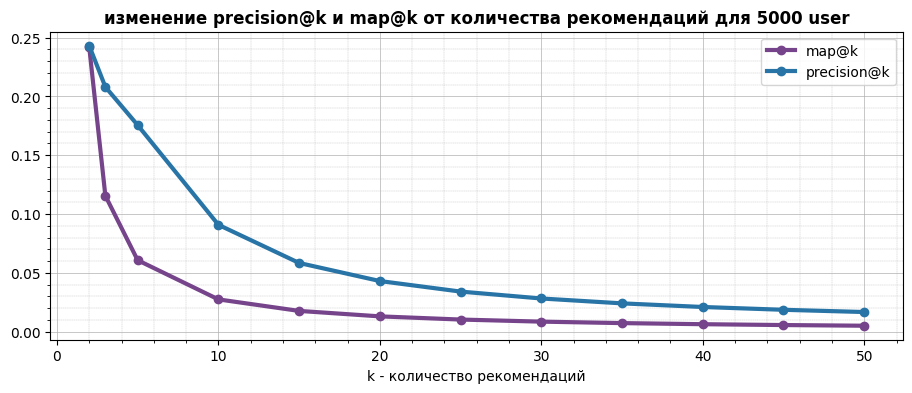

In [16]:
plt.figure(figsize=(11, 4))
plt.plot(count_list, map_list, '-o', c='#76448A', lw=3, label='map@k')
plt.plot(count_list, precision_list, '-o', c='#2874A6', lw=3, label='precision@k')
plt.title('изменение precision@k и map@k от количества рекомендаций для 5000 user', fontweight='bold')
plt.legend()
plt.xlabel('k - количество рекомендаций')
plt.minorticks_on()
plt.grid(which='major', linewidth=.5)
plt.grid(which='minor', linewidth=.25, linestyle='--');

Интерпретируя результаты, можно сделать следующие выводы:

- с увеличением количества рекомендаций значение MAP@k и Precision@k снижается. Это говорит о том, что более широкий список рекомендаций усложняет задачу предсказания релевантных товаров и ухудшает точность модели.

- $\Rightarrow$ для оценки качества рекомендаций важно находить баланс между количеством рекомендаций и их точностью и проводить дополнительные исследования и эксперименты для оптимизации параметров модели.

_____